# Investigating Gas and Stellar Kinematics using Marvin

We're going to study a galaxy (8711-6102) with an inner gas disk that is rotating faster than the stellar disk.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

## 1. Get the Halpha velocity and stellar velocity maps

In [2]:
#from marvin import config
#config.forceDbff()

from marvin.tools.maps import Maps
maps = Maps(plateifu='8711-6102')
havel = maps['emline_gvel_ha_6564']
stvel = maps['stellar_vel']

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


## 2. Create a map of the difference between the Halpha and stellar velocities

Hint: copy one of the maps and modify the `value`, `mask`, and `property_name` attributes. 

In [3]:
maps

<Marvin Maps (plateifu='8711-6102', mode='local', data_origin='db', bintype='HYB10', template='MILESHC-MASTARSSP')>

In [4]:
#diff = copy.deepcopy(stvel)
diff = havel - stvel
diff.ivar = 1. / ((1. / havel.ivar) + (1. / stvel.ivar))
diff.mask = havel.mask | stvel.mask
diff.property_name = 'Ha vel - stellar vel'

## 3. Plot the difference map using the Marvin Maps `plot` function

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Ha vel - stellar vel'}, xlabel='spaxel', ylabel='spaxel'>)

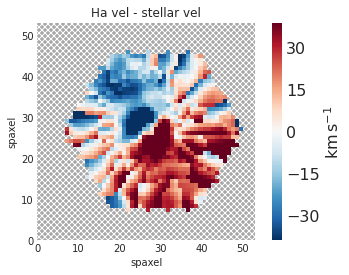

In [5]:
diff.plot(title='Ha vel - stellar vel')

### Bonus: plot Halpha velocity, stellar velocity, and difference maps

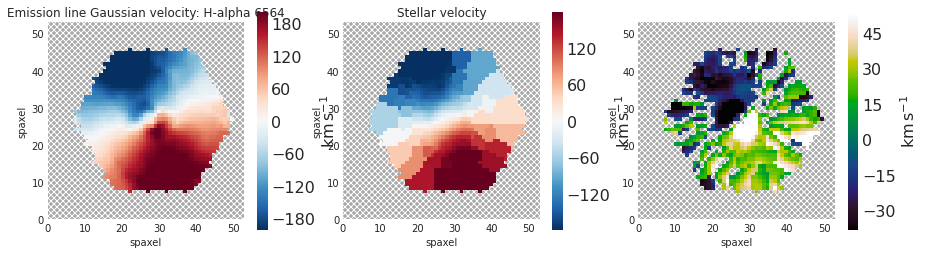

In [6]:
import marvin.utils.plot.map as mapplot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, map_ in zip(axes, [havel, stvel, diff]):
    mapplot.plot(dapmap=map_, fig=fig, ax=ax)

## 4. Stack spectra in inner gas disk

In [7]:
def stack_spectra(ind):
    # get a list of spaxels by passing a list of x-indices and a list of y-indices
    spaxels = maps.getSpaxel(x=ind[0], y=ind[1], xyorig='lower', cube=True)

    # copy the first spaxel so that the stack is a Marvin Spaxel object
    stack = spaxels[0] 
    
    # overwrite the flux with the mean flux of the spectra in the stack (but keep the other meta-data)
    stack.mean_flux = np.mean([sp.flux for sp in spaxels], axis=0)

    return stack

In [8]:
# Stack spectra with (Halpha vel - stellar vel) between -70 and -40
ind_neg = np.where((diff.value > -70) & (diff.value < -40))
stack_neg = stack_spectra(ind_neg)

In [9]:
# Stack spectra with (Halpha vel - stellar vel) between 40 and 70
ind_pos = np.where((diff.value > 40) & (diff.value < 70))
stack_pos = stack_spectra(ind_pos)

## 5. Plot stacked spectra from red and blue sides using Marvin Spectrum `plot` functionality

Hint: divide the Halpha spectrum flux by 2 to get similar normalizations

In [10]:
# adjust continuum normalization for ease of by-eye comparison
stack_pos_adjusted = stack_pos
#stack_pos_adjusted.mean_flux /= 2

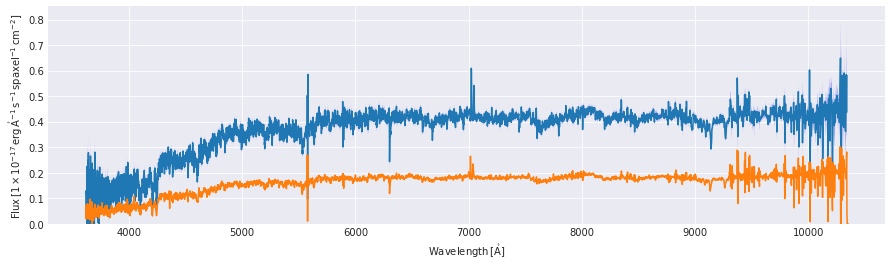

In [11]:
fig = plt.figure(figsize=(15, 4))
ax, fig = stack_neg.flux.plot(figure=fig, return_figure=True)
ax.plot(stack_pos.flux.wavelength, stack_pos_adjusted.mean_flux)

(0.0, 0.3)

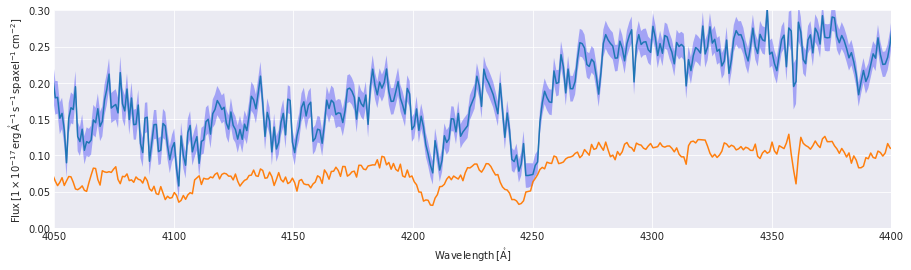

In [21]:
# zoom in on calcium H and K lines
fig = plt.figure(figsize=(15, 4))
#ax, fig = stack_pos_adjusted.flux.plot(figure=fig, return_figure=True)
ax, fig = stack_neg.flux.plot(figure=fig, return_figure=True)
ax.plot(stack_pos.flux.wavelength, stack_pos_adjusted.mean_flux)
ax.set_xlim([4050, 4400])
ax.set_ylim([0., 0.3])

(0.1, 0.7)

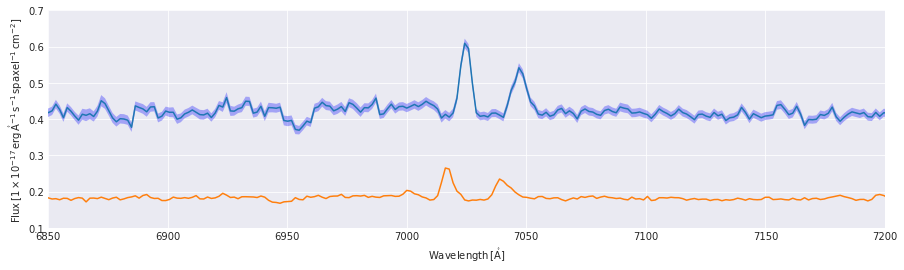

In [20]:
# zoom in on Halpha line
fig = plt.figure(figsize=(15, 4))
#ax, fig = stack_pos_adjusted.spectrum.plot(figure=fig, return_figure=True)
ax, fig = stack_neg.flux.plot(figure=fig, return_figure=True)
ax.plot(stack_pos.flux.wavelength, stack_pos_adjusted.mean_flux)
ax.set_xlim([6850, 7200])
ax.set_ylim([0.1, 0.7])